### ASTR 8070: Astrostatistics
***S. R. Taylor***
___

# Homework 8
### Due: Saturday, Apr 9th at 11.59pm CT
---

## Only one problem this week

1. Use the following code snippet to read in SDSS galaxy color data.
```
from astroML.datasets import fetch_sdss_galaxy_colors
data = fetch_sdss_galaxy_colors()
```
This is a structured numpy array. Find and print all of the column names. Using the data, create arrays of $(u-g)$, $(g-r)$, $(r-i)$, and $(i-z)$ colors. Also create arrays of redshift and the spectral class. How many regular galaxies and how many quasars are in this sample?


2. Make a scatter plot of $(u-g)$ versus $(g-r)$, color coding by galaxy or quasar class. The plot should include appropriate axis labels and a legend. Set `xlim` between -0.5 and 2.5, and `ylim` between -0.5 and 1.5.


3. Stack all colors and the redshift into a data matrix, $X$. Create a target label array that has $0$ for a regular galaxy and $1$ for a quasar. Perform a train-test split, taking $20\%$ of the data for testing.


4. Create a compact `for` loop that iterates over the fitting of a Gaussian Naive Bayes classification algorithm to successively more features of the data. Within the loop, compute and plot an ROC curve. The end result should be a plot showing ROC curves for GNB classification with more and more features of the data, with appropriate axis labels and a legend. Use `xlim` between 0 and 0.01. Which feature seems to make the classification trivially easy? *Note: `predict_proba` returns an array with as many columns as classes. You've labeled quasars as $1$, so for the ROC curve you must make sure to access the relevant quasar probability-- you can find this by accessing the **classes_** attribute of the estimator.*


5. Repeat (4) for Quadratic Discriminant Analysis. 


6. Let's try classification with GMM Bayes. Restrict the training and testing to be just on the $4$ colors. Iterate now over number of components in the GMM Bayes fit up to $10$, plotting ROC curves for all, and find the number of components that gives the best performance.


7. Repeat (6) for $K$-nearest neighbor classification, looping over number of neighbors between 5 and 100 in steps of 10. Find the number that gives the best performance. 


8. Repeat (6) for Decision Tree classification, looping over the maximum tree depth between 1 and 10. Find the number that gives the best performance. 


9. Finally, plot the ROC curves for GNB, QDA, and the best-performing GMMBayes, KNN, and DT classification algorithms, all using just the 4 colors. What is the overall best-performing classifier? 


10. Make a 2-panel plot, showing in the left panel the color-coded training data in $(u-g)$ versus $(g-r)$ (similar to item 2 above), and in the right panel the same features of the testing data color coded by their predicted class from the tuned best-performing classifier. 

### Part 1.1

In [12]:
import numpy as np
from matplotlib import pyplot as plt
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from astroML.classification import GMMBayes
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import roc_curve
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_predict

from astroML.utils import completeness_contamination
from sklearn.model_selection import train_test_split

%matplotlib inline
%config InlineBackend.figure_format='retina'

data = np.load('../../../homeworks/hw_data/hw8_data_1.npy')
print(data.dtype.names)
print(np.unique(data['specClass']))

#(𝑢−𝑔) , (𝑔−𝑟), (𝑟−𝑖), and (𝑖−𝑧)
ug = data['u']-data['g']
gr = data['g']-data['r']
ri = data['r']-data['i']
iz = data['i']-data['z']

redshift = data['redshift']

sp_class = np.zeros(len(data),int)
sp_class[np.where(data['specClass']=='QSO')] = 1

print(f'# Galaxies = {len(data)-np.sum(sp_class)}, # Quasars = {np.sum(sp_class)}')


('u', 'g', 'r', 'i', 'z', 'specClass', 'redshift', 'redshift_err')
['GALAXY' 'QSO']
# Galaxies = 42808, # Quasars = 7192


### Part 1.2

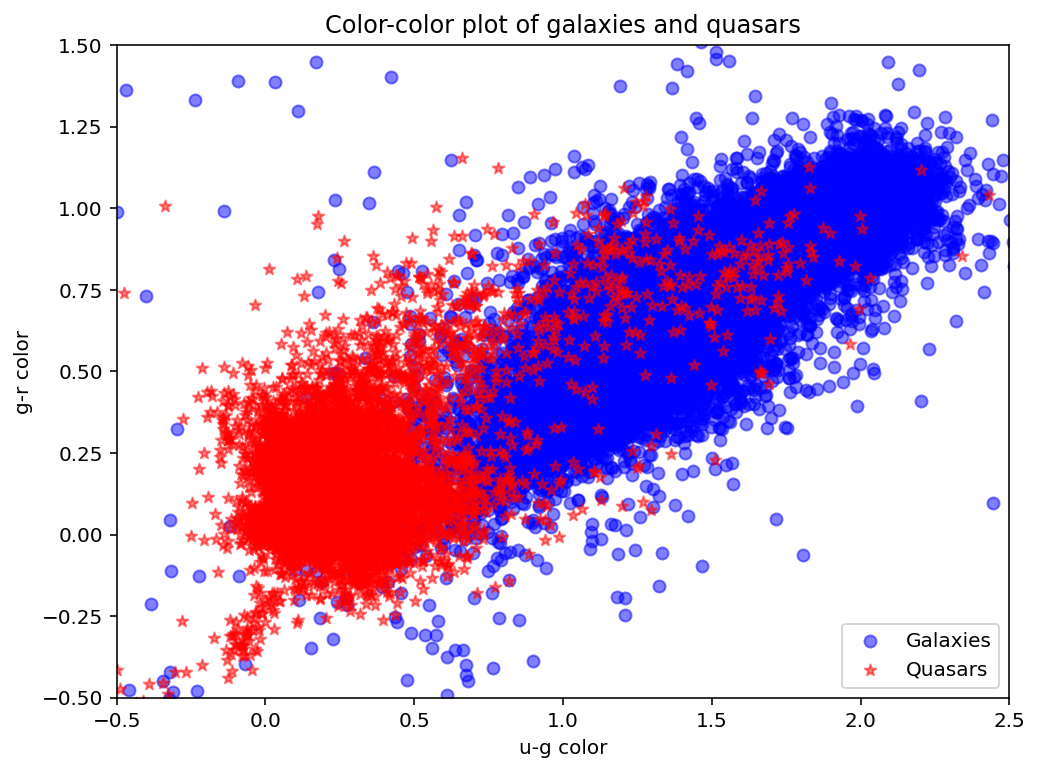

In [13]:
plt.figure(figsize=(8,6))

plt.scatter(ug[np.where(sp_class!=1)],gr[np.where(sp_class!=1)],color='b',alpha=0.5,label='Galaxies')

plt.scatter(ug[np.where(sp_class==1)],gr[np.where(sp_class==1)],marker='*',color='r',alpha=0.5,label='Quasars')

plt.xlim((-0.5,2.5))
plt.ylim((-0.5,1.5))
plt.title('Color-color plot of galaxies and quasars')
plt.xlabel('u-g color')
plt.ylabel('g-r color')
plt.legend()
plt.show()

### Part 1.3

In [14]:
X = np.array([ug,gr,ri,iz,redshift]).T
X_labels = np.array(['u-g','g-r','r-i','i-z','redshift'])
print([f'{n}={round(v,5)}' for n,v in zip(X_labels,X[0])])
print('X shape:',X.shape)

y = sp_class.T
print('y shape:',y.shape)

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2)
print(f'Training size (%) = {len(X_train)/len(X)}')
print(f'Test size (%) = {len(y_test)/len(y)}')

['u-g=0.57029', 'g-r=0.04138', 'r-i=0.02815', 'i-z=0.28811', 'redshift=2.31296']
X shape: (50000, 5)
y shape: (50000,)
Training size (%) = 0.8
Test size (%) = 0.2


### Part 1.4

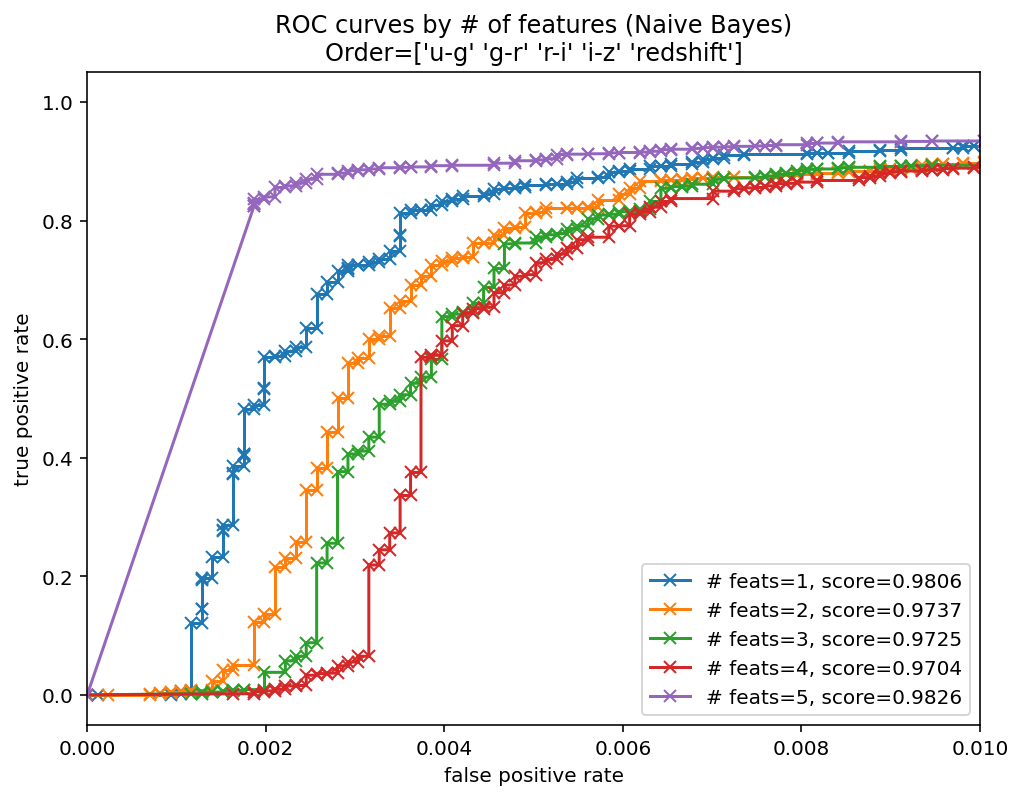

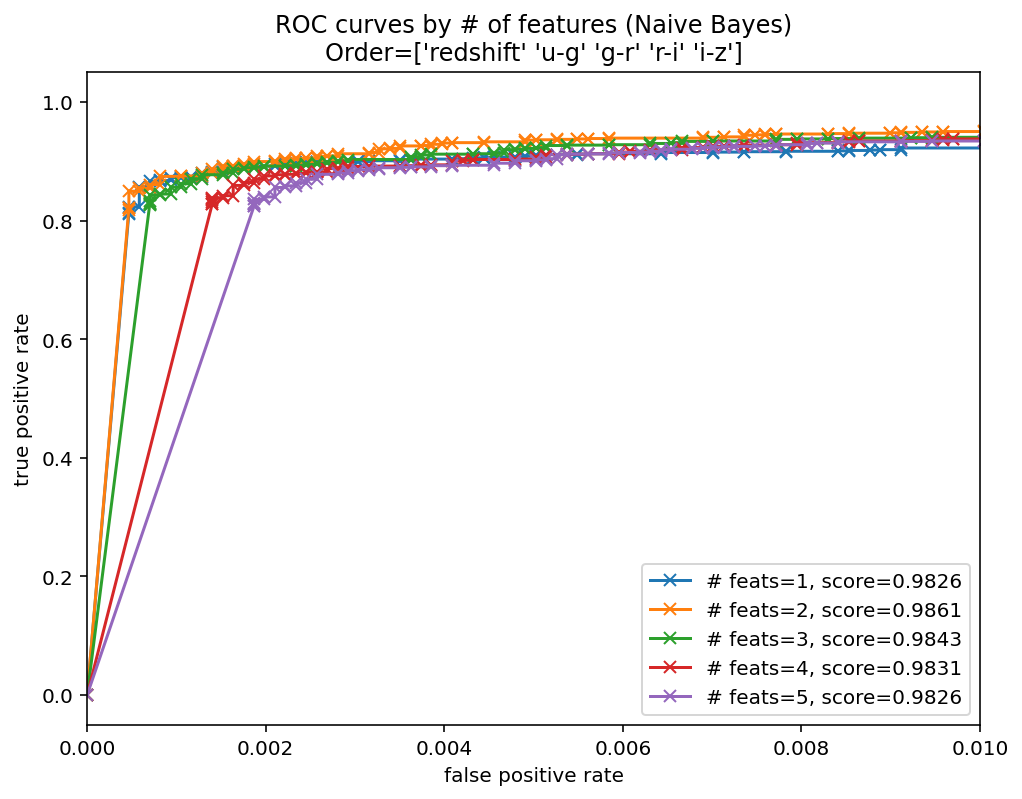

In [15]:
'''
Create a compact for loop that iterates over the fitting of a Gaussian Naive Bayes classification algorithm 
to successively more features of the data. Within the loop, compute and plot an ROC curve. The end result should 
be a plot showing ROC curves for GNB classification with more and more features of the data, with appropriate 
axis labels and a legend. Use xlim between 0 and 0.01. Which feature seems to make the classification trivially 
easy? Note: predict_proba returns an array with as many columns as classes. You've labeled quasars as  1 , so 
for the ROC curve you must make sure to access the relevant quasar probability-- you can find this by accessing 
the classes_ attribute of the estimator.
'''   
plt.figure(figsize=(8,6))

#Order of features should matter here...
order = [0,1,2,3,4]

for i in range(1,len(X_labels)+1):
    X_tr = X_train[:,order]
    X_te = X_test[:,order]
    
    clf = GaussianNB()
    clf.fit(X_tr[:,:i], y_train)
    y_pred = clf.predict(X_te[:,:i])
    y_prob = clf.predict_proba(X_te[:,:i])[:,np.where(clf.classes_==1)[0]]
    
    #Plot ROC curve
    fpr, tpr, thresh = roc_curve(y_test, y_prob)
    
    #Get an accuracy score
    score = accuracy_score(y_test,y_pred)
    
    plt.plot(fpr,tpr,'-x',label=f'# feats={i}, score={round(score,4)}')
    
    

plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.title(f'ROC curves by # of features (Naive Bayes)\nOrder={X_labels[order]}')
plt.legend()
plt.xlim((0,0.01))
plt.show()

plt.figure(figsize=(8,6))
order = [4,0,1,2,3]
for i in range(1,len(X_labels)+1):
    X_tr = X_train[:,order]
    X_te = X_test[:,order]
    
    clf = GaussianNB()
    clf.fit(X_tr[:,:i], y_train)
    y_pred = clf.predict(X_te[:,:i])
    y_prob = clf.predict_proba(X_te[:,:i])[:,np.where(clf.classes_==1)[0]]
    
    #Plot ROC curve
    fpr, tpr, thresh = roc_curve(y_test, y_prob)
    
    #Get an accuracy score
    score = accuracy_score(y_test,y_pred)
    
    plt.plot(fpr,tpr,'-x',label=f'# feats={i}, score={round(score,4)}')
    
    

plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.title(f'ROC curves by # of features (Naive Bayes)\nOrder={X_labels[order]}')
plt.legend()
plt.xlim((0,0.01))
plt.show()

As is shown in the top plot above, using a single parameter, u-g color results in BETTER fitting than with extra features. The one plot that did better than the u-g color was adding redshift. Doing some testing with redshift as the first parameter results in very high scores. Adding u-g increased the score slightly, but adding more parameters than that made the prediction WORSE.

Therefore, the two most important parameters for predicting quasars was redshift (slightly better single parameter score), then u-g. The other parameters only worsened the predictions

### Part 1.5

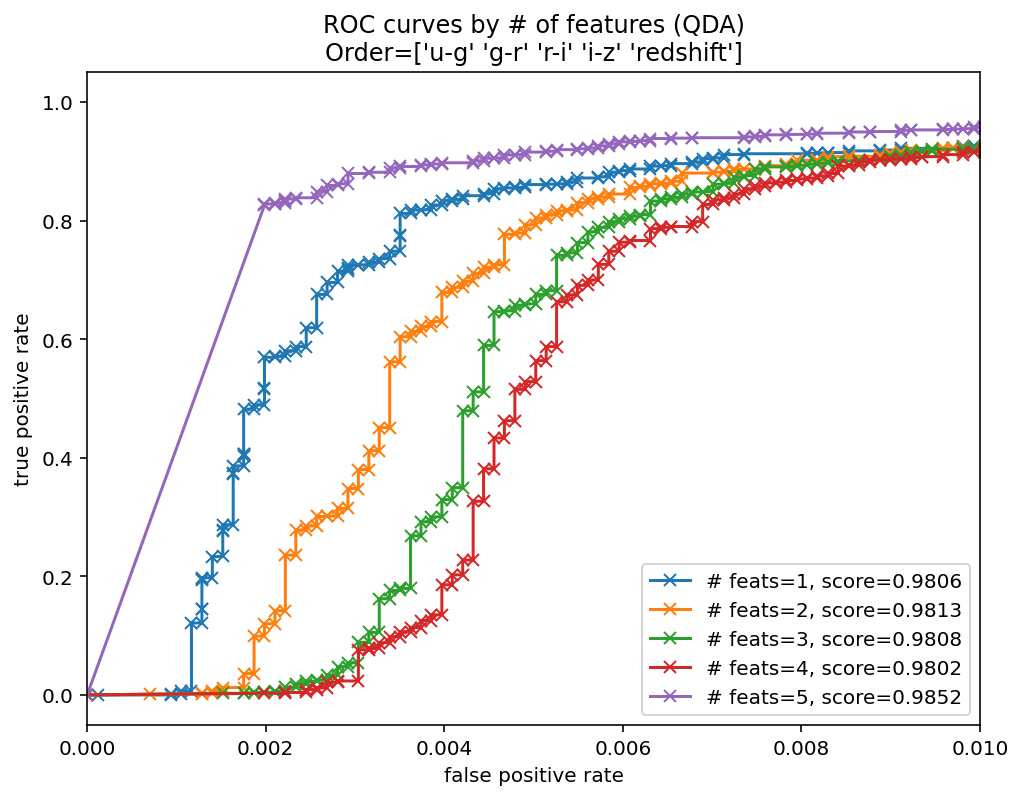

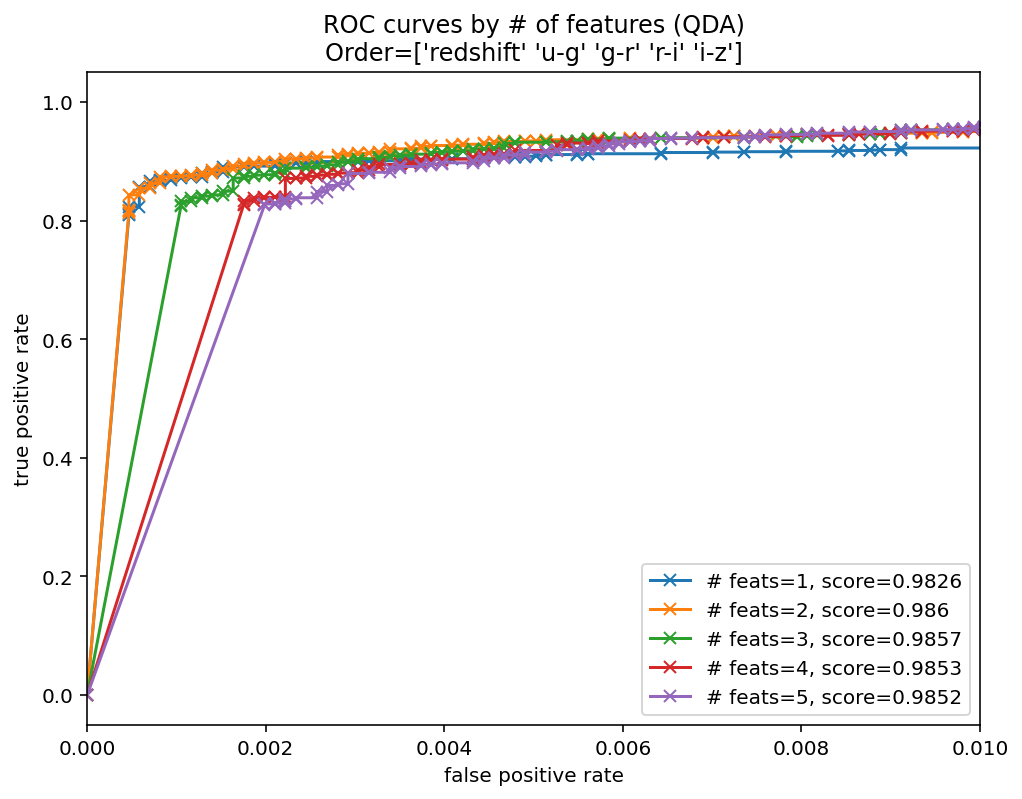

In [16]:
'''Repeat (4) for Quadratic Discriminant Analysis.'''
 
plt.figure(figsize=(8,6))

#Order of features should matter here...
order = [0,1,2,3,4]

for i in range(1,len(X_labels)+1):
    X_tr = X_train[:,order]
    X_te = X_test[:,order]
    
    qda = QuadraticDiscriminantAnalysis()
    qda.fit(X_tr[:,:i], y_train)
    y_pred = qda.predict(X_te[:,:i])
    y_prob = qda.predict_proba(X_te[:,:i])[:,np.where(qda.classes_==1)[0]]
    
    #Plot ROC curve
    fpr, tpr, thresh = roc_curve(y_test, y_prob)
    
    #Get an accuracy score
    score = accuracy_score(y_test,y_pred)
    
    plt.plot(fpr,tpr,'-x',label=f'# feats={i}, score={round(score,4)}')
    
    

plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.title(f'ROC curves by # of features (QDA)\nOrder={X_labels[order]}')
plt.legend()
plt.xlim((0,0.01))
plt.show()

plt.figure(figsize=(8,6))
order = [4,0,1,2,3]
for i in range(1,len(X_labels)+1):
    X_tr = X_train[:,order]
    X_te = X_test[:,order]
    
    qda = QuadraticDiscriminantAnalysis()
    qda.fit(X_tr[:,:i], y_train)
    y_pred = qda.predict(X_te[:,:i])
    y_prob = qda.predict_proba(X_te[:,:i])[:,np.where(qda.classes_==1)[0]]
    
    #Plot ROC curve
    fpr, tpr, thresh = roc_curve(y_test, y_prob)
    
    #Get an accuracy score
    score = accuracy_score(y_test,y_pred)
    
    plt.plot(fpr,tpr,'-x',label=f'# feats={i}, score={round(score,4)}')
    
    

plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.title(f'ROC curves by # of features (QDA)\nOrder={X_labels[order]}')
plt.legend()
plt.xlim((0,0.01))
plt.show()

Unsurprisingly, QDA gives exactly the same results for single features, since the relaxed requirement of equal covariances doesn't apply for 1 parameter. However, the scores for the combined features increased a bit! for 5 features with the first order, the scores increase from 0.9842 to 0.9865. Not incredibly different, but better regardless.

### Part 1.6

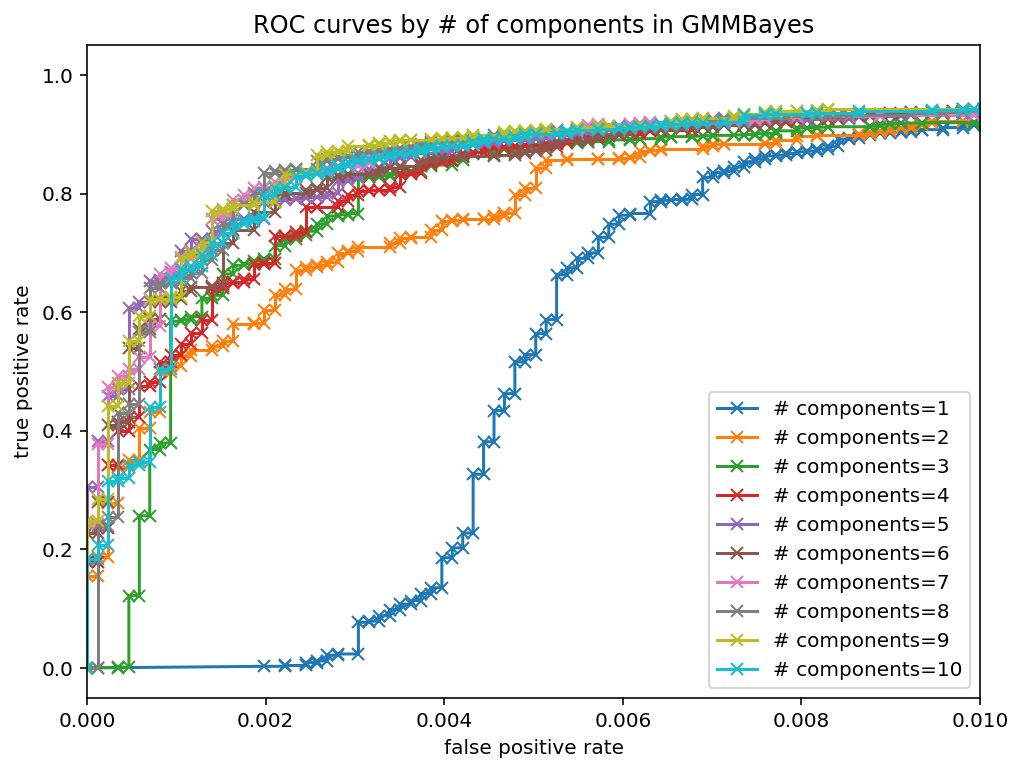

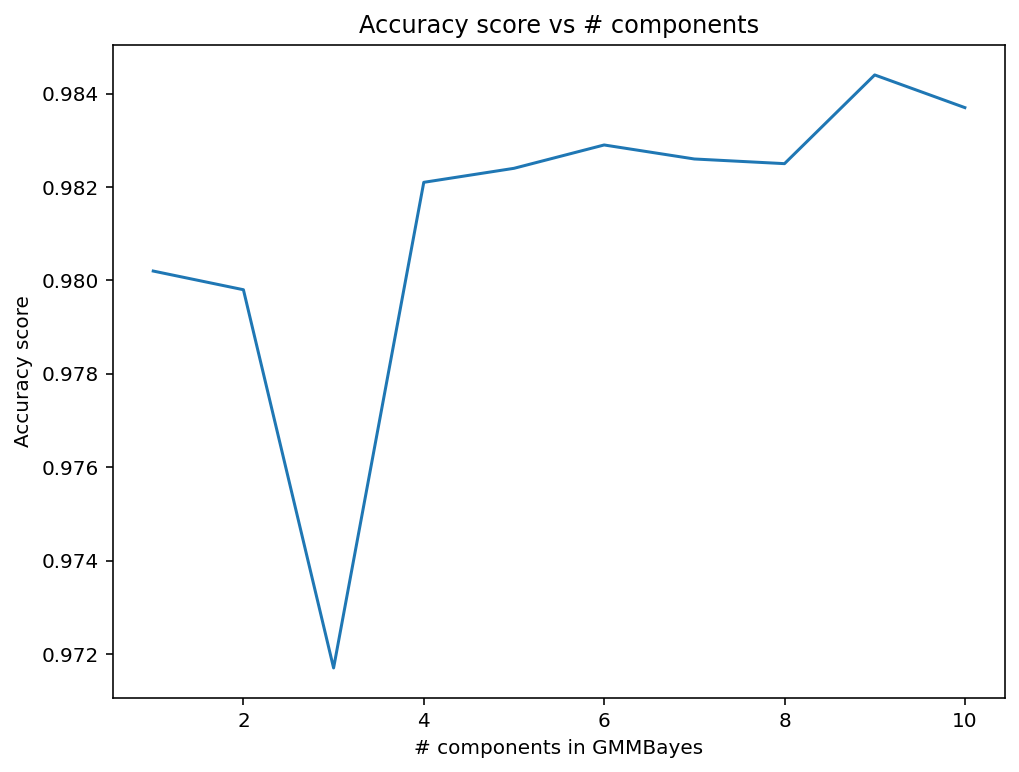

Best n_components=9


In [18]:
'''Let's try classification with GMM Bayes. Restrict the training and testing to be just on the  4  colors. 
Iterate now over number of components in the GMM Bayes fit up to  10 , plotting ROC curves for all, and 
find the number of components that gives the best performance.'''

plt.figure(figsize=(8,6))
scores = []
for i in range(1,11):
    gmmb = GMMBayes(n_components=i)
    gmmb.fit(X_train[:,:4],y_train)
    
    y_pred = gmmb.predict(X_test[:,:4])
    y_prob = gmmb.predict_proba(X_test[:,:4])[:,np.where(gmmb.classes_==1)[0]]
    
    #Plot ROC curve
    fpr, tpr, thresh = roc_curve(y_test, y_prob)
    
    #Get an accuracy score
    score = accuracy_score(y_test,y_pred)
    scores.append(score)
    
    plt.plot(fpr,tpr,'-x',label=f'# components={i}')
    
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.title(f'ROC curves by # of components in GMMBayes')
plt.legend()
plt.xlim((0,0.01))
plt.show()

plt.figure(figsize=(8,6))
plt.plot(list(range(1,11)),scores)
plt.title('Accuracy score vs # components')
plt.xlabel('# components in GMMBayes')
plt.ylabel('Accuracy score')
plt.show()
print(f'Best n_components={list(range(1,11))[np.argmax(scores)]}')

NOTE: This result is NOT stable, multiple runs results in slightly different results. For better results, I could use k-fold cross validation (Not done here)

### Part 1.7

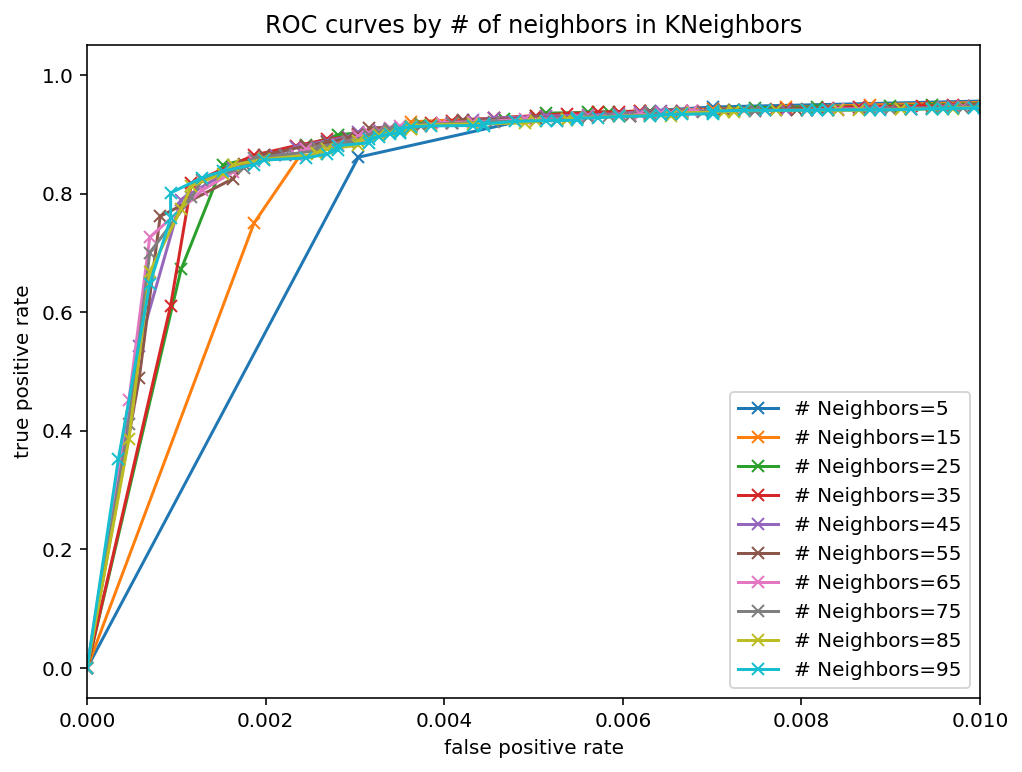

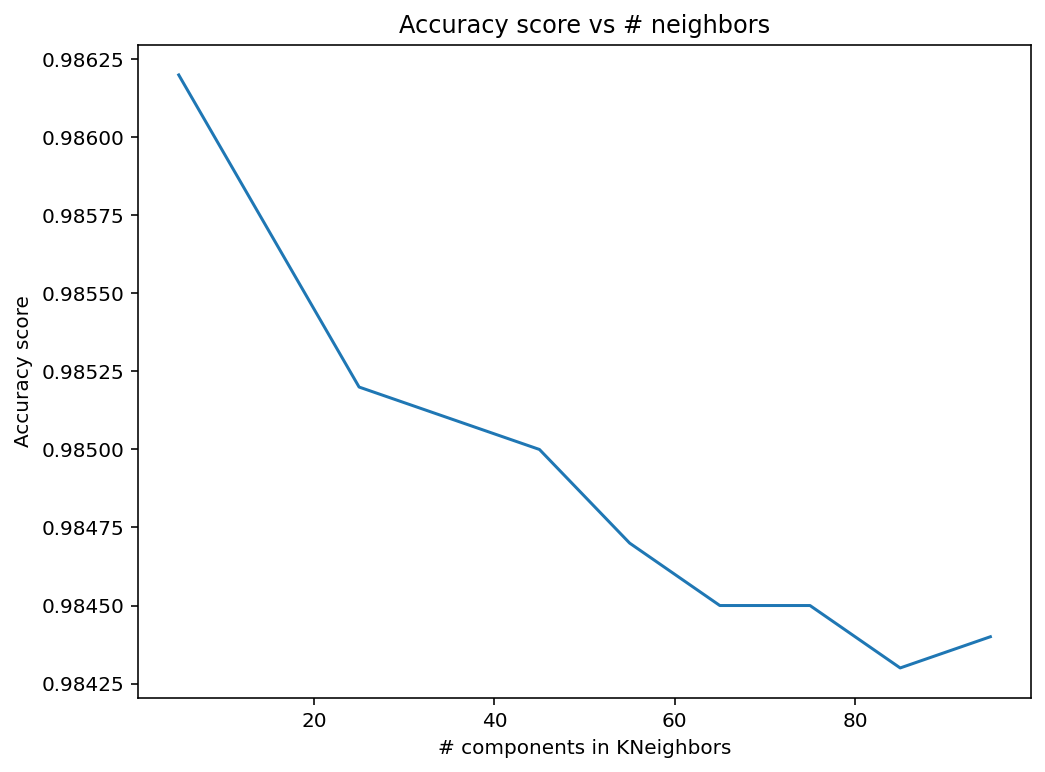

Best n_neighbors=5


In [20]:
'''Repeat (6) for  𝐾 -nearest neighbor classification, looping over number of neighbors between 5 and 100 in 
steps of 10. Find the number that gives the best performance.
'''
plt.figure(figsize=(8,6))
scores = []

for i in np.arange(5,100,10):
    knnc = KNeighborsClassifier(n_neighbors=i)
    knnc.fit(X_train[:,:4],y_train)
    
    y_pred = knnc.predict(X_test[:,:4])
    y_prob = knnc.predict_proba(X_test[:,:4])[:,np.where(knnc.classes_==1)[0]]
    
    #Plot ROC curve
    fpr, tpr, thresh = roc_curve(y_test, y_prob)
    
    #Get an accuracy score
    score = accuracy_score(y_test,y_pred)
    scores.append(score)
    
    plt.plot(fpr,tpr,'-x',label=f'# Neighbors={i}')#, score={round(score,4)}')
    
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.title(f'ROC curves by # of neighbors in KNeighbors')
plt.legend()
plt.xlim((0,0.01))
plt.show()


plt.figure(figsize=(8,6))
plt.plot(np.arange(5,100,10),scores)
plt.title('Accuracy score vs # neighbors')
plt.xlabel('# components in KNeighbors')
plt.ylabel('Accuracy score')
plt.show()
print(f'Best n_neighbors={np.arange(5,100,10)[np.argmax(scores)]}')

While GMMBayes was not stable, this one KNeighbors is stable

### Part 1.8

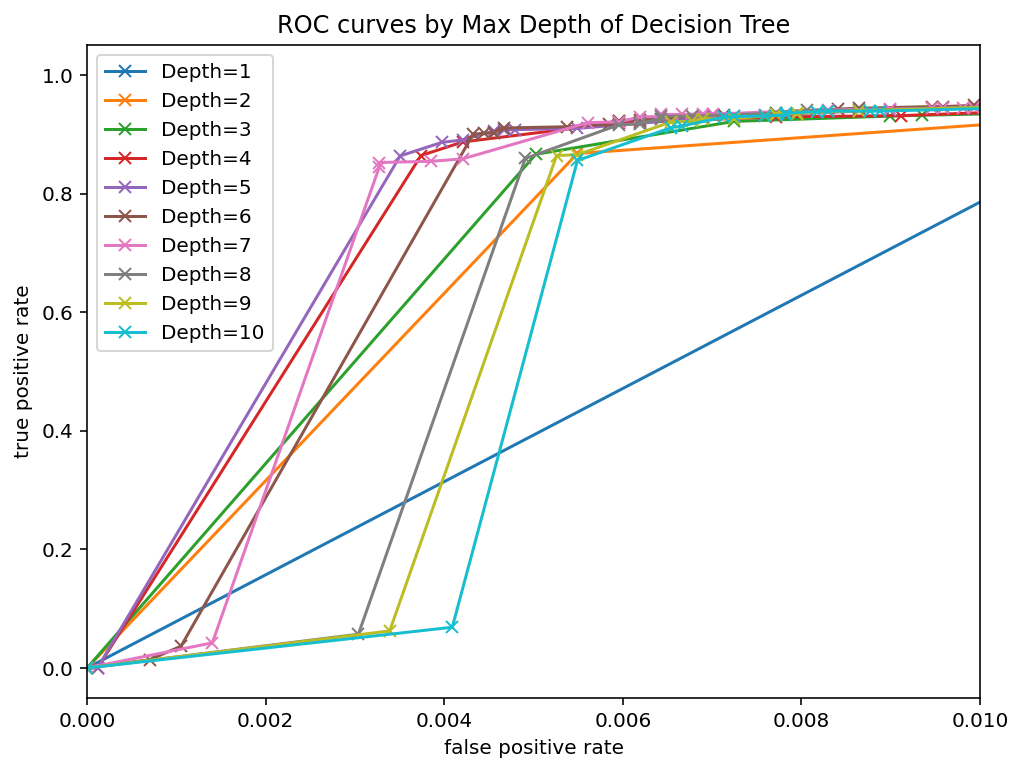

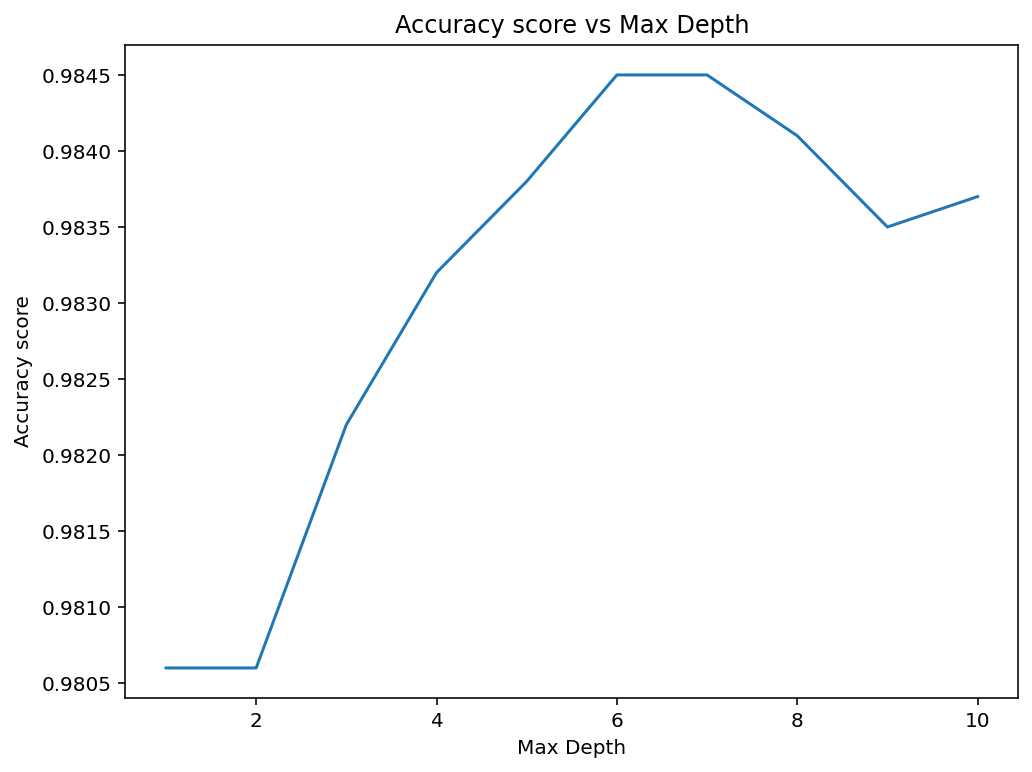

Best depth=6


In [21]:
'''Repeat (6) for Decision Tree classification, looping over the maximum tree depth between 1 and 10. 
Find the number that gives the best performance.'''

plt.figure(figsize=(8,6))
scores = []

for i in range(1,11):
    dtc = DecisionTreeClassifier(max_depth=i)
    dtc.fit(X_train[:,:4],y_train)
    
    y_pred = dtc.predict(X_test[:,:4])
    y_prob = dtc.predict_proba(X_test[:,:4])[:,np.where(dtc.classes_==1)[0]]
    
    #Plot ROC curve
    fpr, tpr, thresh = roc_curve(y_test, y_prob)
    
    #Get an accuracy score
    score = accuracy_score(y_test,y_pred)
    scores.append(score)
    
    plt.plot(fpr,tpr,'-x',label=f'Depth={i}')
    
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.title(f'ROC curves by Max Depth of Decision Tree')
plt.legend()
plt.xlim((0,0.01))
plt.show()


plt.figure(figsize=(8,6))
plt.plot(list(range(1,11)),scores)
plt.title('Accuracy score vs Max Depth')
plt.xlabel('Max Depth')
plt.ylabel('Accuracy score')
plt.show()
print(f'Best depth={list(range(1,11))[np.argmax(scores)]}')

This is another unstable plot that can be stabilized with K-fold cross validation

### Part 1.9

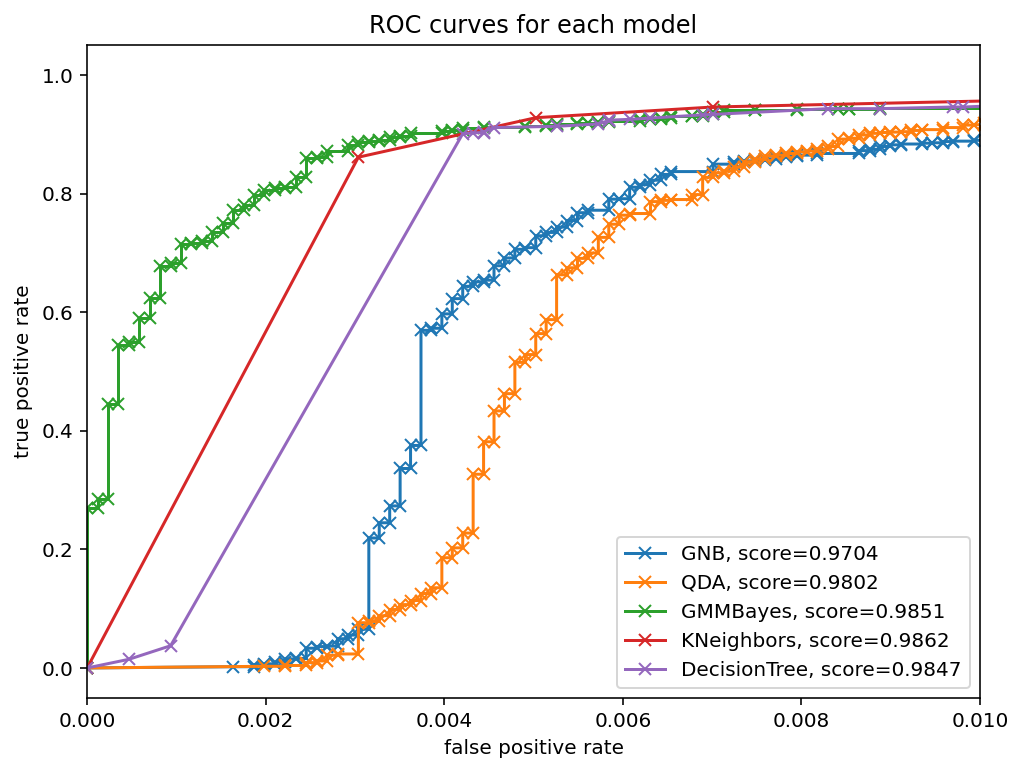

In [22]:
'''Finally, plot the ROC curves for GNB, QDA, and the best-performing GMMBayes, KNN, and DT classification 
algorithms, all using just the 4 colors. What is the overall best-performing classifier'''
models = [GaussianNB(),QuadraticDiscriminantAnalysis(),
          GMMBayes(n_components=9),KNeighborsClassifier(n_neighbors=5),
          DecisionTreeClassifier(max_depth=6)
         ]
names = ['GNB','QDA','GMMBayes','KNeighbors','DecisionTree']

plt.figure(figsize=(8,6))
for i,m in enumerate(models):
    m.fit(X_train[:,:4],y_train)
    
    y_pred = m.predict(X_test[:,:4])
    y_prob = m.predict_proba(X_test[:,:4])[:,np.where(m.classes_==1)[0]]
    
    #Plot ROC curve
    fpr, tpr, thresh = roc_curve(y_test, y_prob)
    
    #Get an accuracy score
    score = accuracy_score(y_test,y_pred)
    
    plt.plot(fpr,tpr,'-x',label=f'{names[i]}, score={score}')

plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.title(f'ROC curves for each model')
plt.legend()
plt.xlim((0,0.01))
plt.show()


### Part 1.10

The best model here is K-Neighbors!

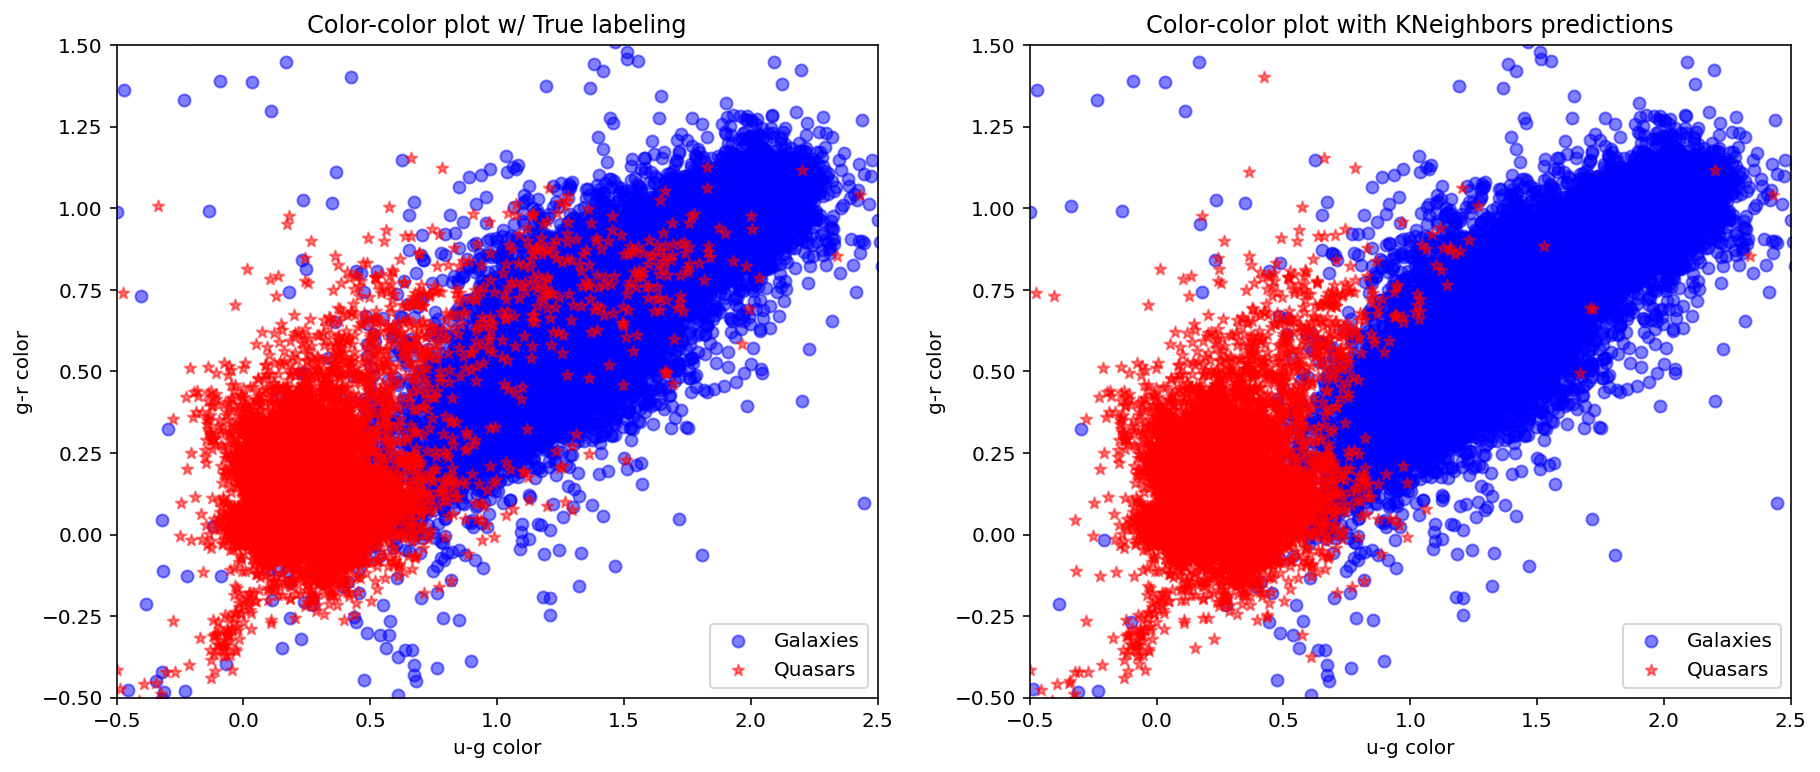

In [23]:
'''Make a 2-panel plot, showing in the left panel the color-coded training data in  (𝑢−𝑔)  versus  (𝑔−𝑟)  
(similar to item 2 above), and in the right panel the same features of the testing data color coded 
by their predicted class from the tuned best-performing classifier.'''

plt.figure(figsize=(15,6))

plt.subplot(1,2,1)
plt.scatter(ug[np.where(sp_class!=1)],gr[np.where(sp_class!=1)],color='b',alpha=0.5,label='Galaxies')
plt.scatter(ug[np.where(sp_class==1)],gr[np.where(sp_class==1)],marker='*',color='r',alpha=0.5,label='Quasars')
plt.xlim((-0.5,2.5))
plt.ylim((-0.5,1.5))
plt.title('Color-color plot w/ True labeling')
plt.xlabel('u-g color')
plt.ylabel('g-r color')
plt.legend()


plt.subplot(1,2,2)
pred_class = models[3].predict(X[:,:4]) 

plt.scatter(ug[np.where(pred_class!=1)],gr[np.where(pred_class!=1)],color='b',alpha=0.5,label='Galaxies')
plt.scatter(ug[np.where(pred_class==1)],gr[np.where(pred_class==1)],marker='*',color='r',alpha=0.5,label='Quasars')
plt.xlim((-0.5,2.5))
plt.ylim((-0.5,1.5))
plt.title('Color-color plot with KNeighbors predictions')
plt.xlabel('u-g color')
plt.ylabel('g-r color')
plt.legend()
plt.show()

In [24]:
#Get correct classification percent
sp_class = sp_class.astype(bool)
pred_class = pred_class.astype(bool)
tot_acc = np.sum(sp_class & pred_class)/np.sum(sp_class)
print(f'Total accuracy = {tot_acc}')

Total accuracy = 0.9488320355951056
